## Ch. 02- Programming Probabilistically

In [1]:
# Import pymc and related code
import arviz as az
import pymc as pm
import preliz as pz

In [2]:
# Import other "data science libraries"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2.1 Probabilistic programming

#### 2.1.1 Flipping coins the PyMC way2.1.1 Flipping coins the PyMC way

In [3]:
# Initialize repeatable random number generator
rng = np.random.default_rng(123)

In [4]:
# Generate "fake real data"
trials = 4
theta_real = 0.35 # unknown in a real experiment
data = pz.Binomial(
    n=1,
    p=theta_real).rvs(trials,
                      random_state=rng.integers(np.iinfo(np.int32).max))

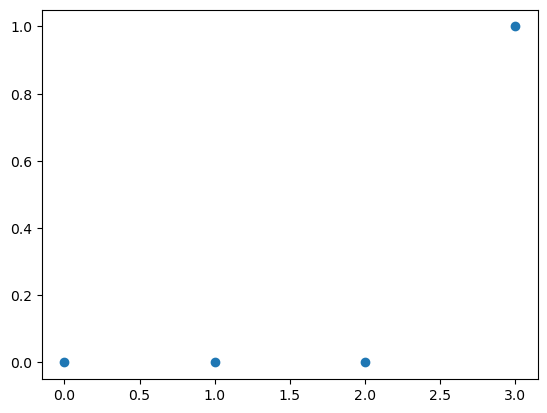

In [5]:
plt.scatter(range(trials), data)
plt.show()

In [6]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


### 2.2 Summarizing the posterior

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

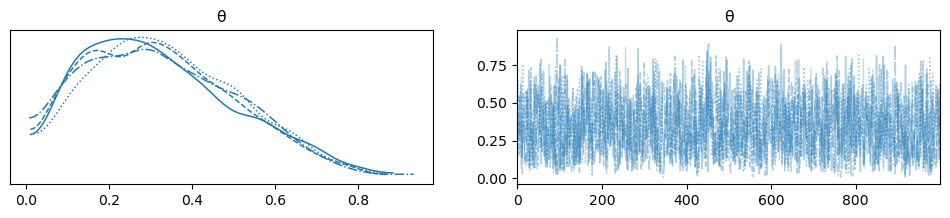

In [7]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'θ'}>,
        <Axes: title={'center': 'θ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

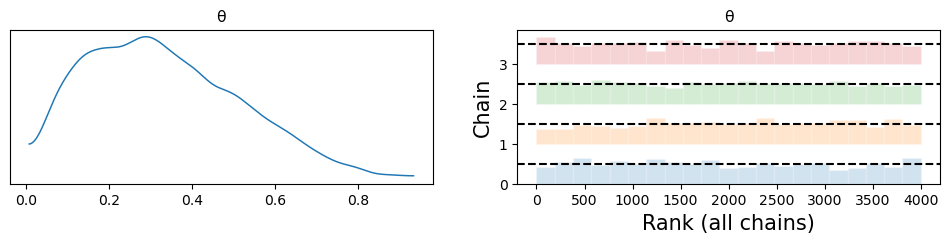

In [8]:
az.plot_trace(idata, kind='rank_bars', combined=True)

<Axes: title={'center': 'θ'}>

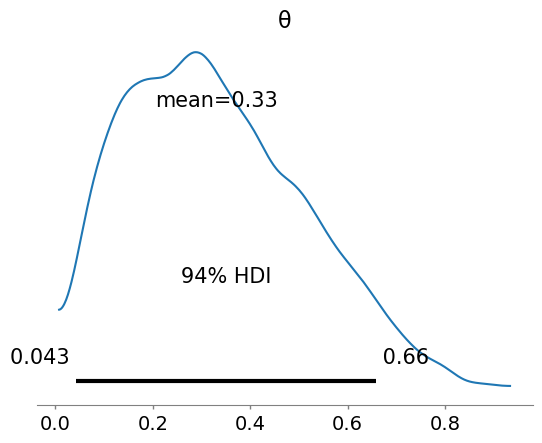

In [9]:
az.plot_posterior(idata)

### 2.3 Posterior-based decisions

#### 2.3.1 Savage-Dickey density ration

({'BF10': 0.8150994894940763, 'BF01': 1.226844100492186},
 <Axes: title={'center': 'The BF_10 is 0.82\nThe BF_01 is 1.23'}, xlabel='θ', ylabel='Density'>)

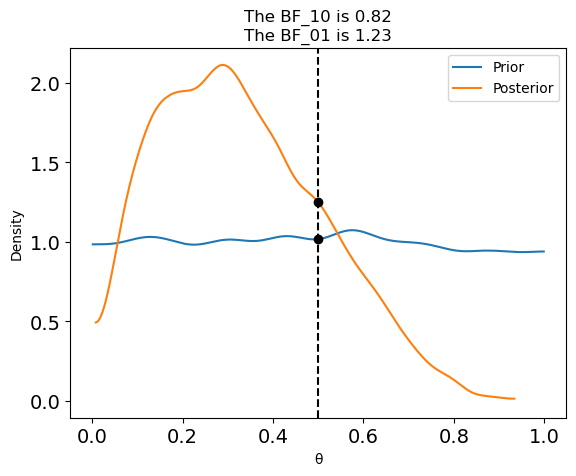

In [10]:
az.plot_bf(idata, var_name='θ', prior=rng.uniform(0, 1, 10000), ref_val=0.5)

#### 2.3.2 Region of Practical Equivalence

<Axes: title={'center': 'θ'}>

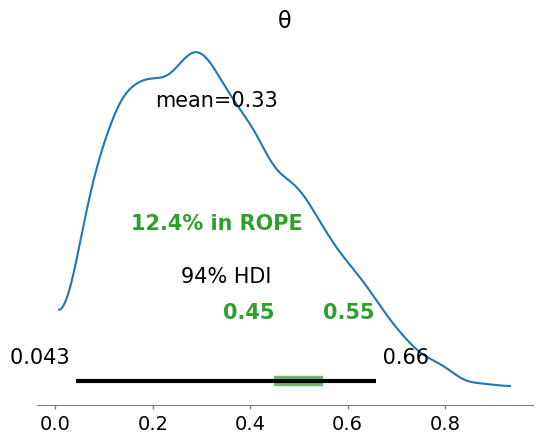

In [11]:
az.plot_posterior(idata, rope=[0.45, 0.55])

<Axes: title={'center': 'θ'}>

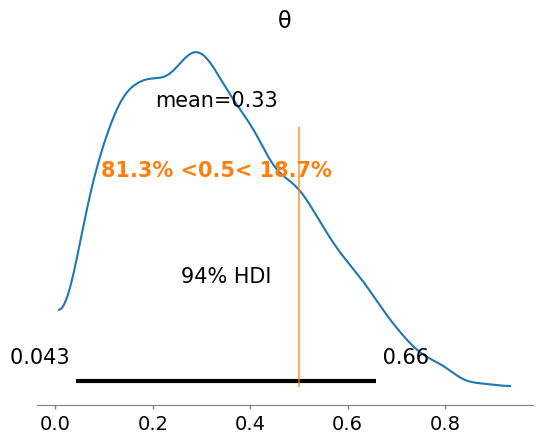

In [12]:
az.plot_posterior(idata, ref_val=0.5)

#### 2.3.3 Loss functions

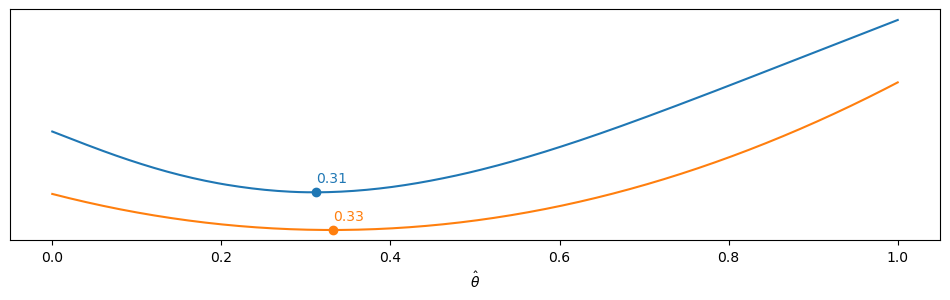

In [13]:
# Plot the loss
# The plotting part of this code is from 
# [the chapter 02 code](https://github.com/aloctavodia/BAP3/blob/main/code/Chp_02.ipynb).
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos) ** 2) for i in grid]

_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
                (grid[mini], lossf[mini] + 0.03),
                color=c)

    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

plt.show()

In [14]:
# A (silly) assymetric loss function
lossf = []
for i in grid:
    if i < 0.5:
        f = 1 / np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos) ** 2 + np.exp(-i)) - 0.25

    lossf.append(f)

Text(0.5, 0, '$\\hat \\theta$')

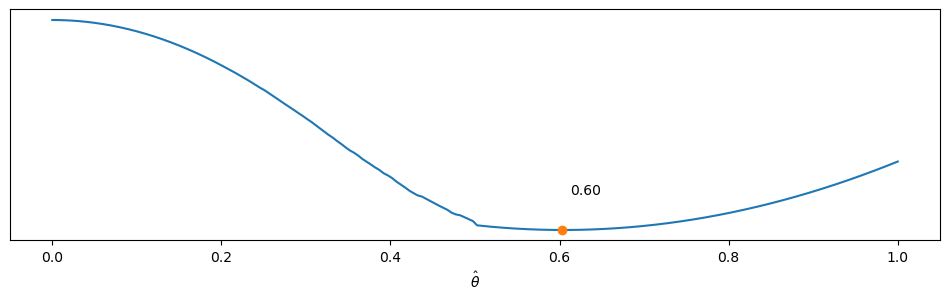

In [15]:
# Plot the (silly) asymmetric loss function
mini = np.argmin(lossf)
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(grid, lossf)
ax.plot(grid[mini], lossf[mini], 'o')
ax.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
ax.set_yticks([])
ax.set_xlabel(r'$\hat \theta$')

### 2.4 Gaussians all the way down

Gaussians are very appealing. They are easy to work with,
many operations applied to Gaussians return another Gaussian.
Additionally, many natural phenomena can be approximated using
Gaussians. In general, almost every time we measure the average
of something, using a **big enough** sample size, the average
will be distributed as a Gaussian.

Many phenomena are indeed averages. For example, the height
of adults. (Actually, this distribution is a **mixture** of
**two** Gaussians - one for men and one for women.)

Consequently, it is important to learn to build Gaussians,
but also to learn how to relax the normality assumptions.
(This relaxation is surprisingly easy with tools like PyMC).



#### 2.4.1 Gaussian inferences

**Background**

We can use nuclear magnetic Resonance (NMR) to study molecules or
living things such as humans, sunflowers, and yeast. NMR allows one
to measure different **observable** quantities related to **unobservable**
molecular properties. Chemical shift is one of these observable
properties that apply to the nuclei of certain types of atoms.
This problem is an example similar to:

- The height of a group of people
- The average time to travel back home
- The weights of bags or oranges

All these examples have continuous variables and can be thought of as an
average plus a dispersion.

Additionally, if the number of possible values is large enough, we can
approximate it using a Gaussian. For example, the sexual partners of
bonobos, a very promiscuous monkey.

In our example, we have 48 chemical shift value.

- The median is around 53
- The inter-quartile range is about 52 to 55
- Two values "far away" from the resto of the data appear to be outliers.

In [16]:
# Load the data
data = np.loadtxt('./data/chemical_shifts.csv')

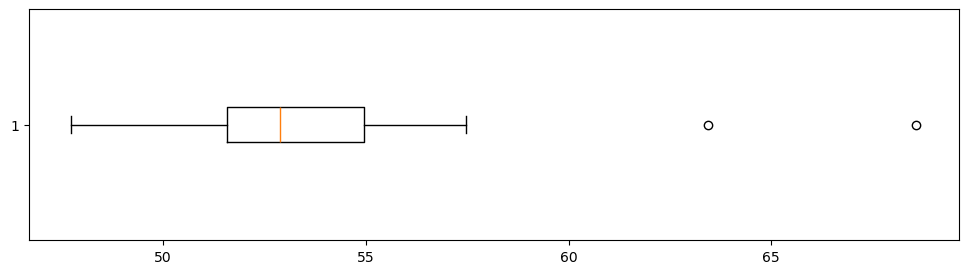

In [17]:
# Plot the data using a boxplot
_, ax = plt.subplots(figsize=(12, 3))
ax.boxplot(data, vert=False)
plt.show()

We'll forget about the two outlying points. We will further assume that
a Gaussian is a good description of the data. Since know neither the mean
nor the standard deviation, we set priors for both of them. Therefore, a
reasonable model is:

$$
\begin{gather}
\mu \sim \mathcal{U(l, h)} \\
\sigma \sim \mathcal{HN(\sigma_{\sigma})} \\
Y \sim \mathcal{N(\mu, \sigma)}
\end{gather}
$$

where

- $\mathcal{U(l, h)}$ is the Uniform distribution between
  $\mathcal{l}$ and $\mathcal{h}$
- $\mathcal{HN(\sigma_{\sigma})}$ is the Half-Normal distribution
  with scale $\mathcal{\sigma_{\sigma}}$
- $\mathcal{N(\mu, \sigma)}$ is the Gaussian distribution with mean,
  $\mathcal{\mu}$, and standard deviation, $\mathcal{\sigma}$.

Since we do not know the possible values of $\mu$ and $\sigma$ - a typical
situation - we can set priors reflecting our ignorance. For example, we
can set the boundaries of our uniform distribution to be
$\mathcal{l} = 40$ and $\mathcal{h} = 75$: a range **larger** than the
range of the data.

For the Half-Normal, in the absence of more information, we can choose a
large value compared to the **scale** of the data. The following PyMC
code puts details to our model.

In [18]:
with pm.Model() as model_g:
    mu = pm.Uniform('\u03bc', lower=40, upper=70)
    sigma = pm.HalfNormal('\u03c3', sigma=5)
    Y = pm.Normal('Y', mu=mu, sigma=sigma, observed=data)
    idata_g = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


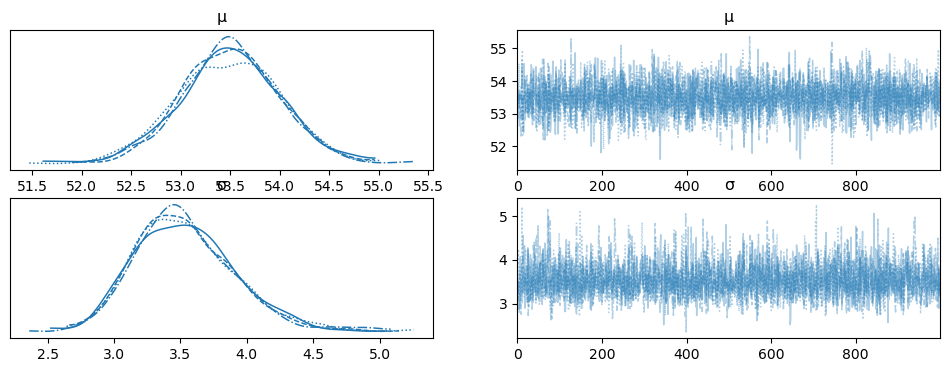

In [19]:
az.plot_trace(idata_g)
plt.show()

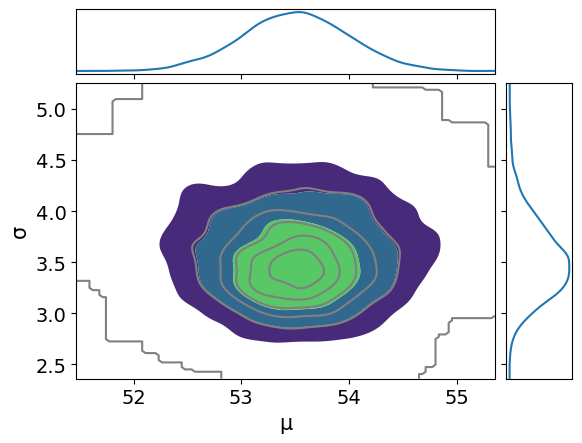

In [20]:
az.plot_pair(idata_g, kind='kde', marginals=True)
plt.show()

In [21]:
az.summary(idata_g, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
μ,53.50,0.50,52.54,54.44
σ,3.54,0.38,2.84,4.23


### Posterior predictive checks

One nice element of the Bayesian toolkit. Once one has calculated
the posterior, $P(\theta | Y)$, one can use that posterior to
generate predictions, $p(\tilde{Y})$.

Although calculating the posterior involves an integral, using PyMC
to get posterior predictive samples involves:

- Calling the function, `sample_posterior_predictive()`
- Passing `InferenceData` as the first object

Additionally, we must pass the `model` object, and we **may** use
the `extend_Inferencedata` argument to add the posterior predictive
samples to the `InferenceData` object.

In [22]:
pm.sample_posterior_predictive(
    idata_g,
    model=model_g,
    extend_inferencedata=True,
)

Sampling: [Y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Additionally, we can plot the posterior predictive checks.

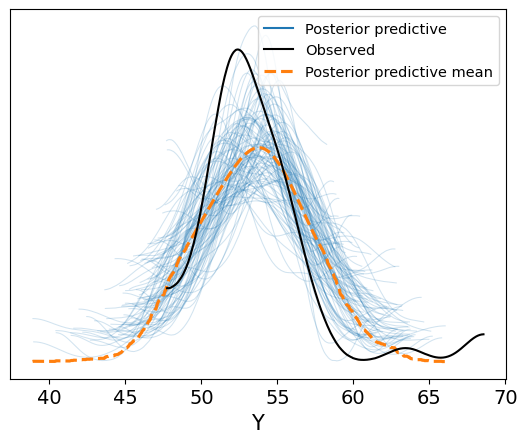

In [23]:
az.plot_ppc(idata_g, num_pp_samples=100)
plt.show()

This plot contains

| Curve | Explanation |
| ----- | ----------- |
| White | Kernel Density Estimate (KDE) of the observed data |
| Blue | KDEs computed from each of the 100 posterior predictive samples |
| Orange | Posterior predictive mean |

The blue lines reflect our uncertainty of the predicted data. The plots are
_hairy_ or _wonky_ to reflect our (relative) **lack of data**.
We can make additional observations about our simulated data. For example,
the mean of the simulated data is displaced to the right with a slightly
larger variance that the variance of the actual data.

This discrepancy results from

- Our choice of likelihood
- The two observations away from the bulk of the data

How do we interpret this plot? Is the model wrong or right? Can we use it
or do we need a different model?

Well, it depends. The interpretation of a model and its evaluation and
criticism are **always** context dependent.

The author, based on his experience, believes that this model is a
reasonable enough representation of the data **and** a useful one
for most analyses.

However, we could find other models the better fit the whole data set,
including the two observations that are **far** from the bulk of the
data. We'll see how we can do that next.

### 2.6 Robust inferences

One objection we may have with `model_g` is that we are assuming
a Normal distribution. However, as we have mentioned, our data has two
points away from the bulk of the data. Our choice of a Normal
distribution for the likelihood indirectly assumes that we **do not expect**
to see a lot of data points far away from the bulk of the data.

Since the tails of the Normal distribution fall off quickly as we move
away from the mean, the Normal distribution **is surprised** at the two
"extreme" points.

The distribution "reacts" in two ways:

- It moves its mean towards those two extreme points
- It increases its standard deviation

What can we do? We have at least two options:

We can check for errors in the data; for example,

- During cleaning or preprocessing of the data
- Resulting from the malfunction of the measuring equipment

This conclusion may not be helpful. For example, if the data was actually
collected by someone else, we may not be able to reliable draw
these conclusions.

Another option is to declare the two points outliers and remove theme from
the data. Two common rules for identifying outliers are:

- Any point that falls **below** 1.5 x the IQR (inter-quartile range)
  from the lower quartile or falls **above** 1.5 times  the IQR from
  the upper quartile is considered an outlier.
- Any data point that falls below or above N times the standard deviation
  of the data is considered an outlier. In this situation, N usually has
  a value of 2 or 3.

However, as with **any automatic "method"**, these rules of thumb
**are not perfect** and may result in discarding **valid data points.**

As a general rule, Baysians prefer to encode assumptions directly into the
model by using different priors and likelihood rather than appealing to
_ad hoc_ heuristics such as outlier removal rules.

#### 2.6.1 Degree of normality

One distribution is very similar to a Normal distribution. It has three
parameters and is called the Student's t-distribution:

- A location parameter, $\mu$.
- A scale parameter, $\sigma$.
- A normality parameter, $\nu$. (AKA, the degrees of freedom.)

| When...          | Then, the distribution is the... |
|------------------|----------------------------------|
| $\nu$ = $\infty$ | Normal distribution |
| $\nu$ = 1        | Cauchy or Lorentz distribution |

The parameter, $\nu$, has the range [0, $\infty$]. The lower the
value of $\nu$, the heavier the tails of the distribution.
Alternatively, the lower the value of $\nu$, the higher the
kurtosis. Additionally, if $\nu \leq 1$, the mean value of
the Student's T distribution is not defined. However, remember
that we can **always** calculate an empirical mean.

Similarly, the variance of the Student's T distribution is only defined
for values of $\nu > 2$. Additionally, the **scale** of the Student's T
distribution is **not** the same as its **standard deviation**. However,
the scale and the standard deviation become closer and closer as $\nu$
approaches infinity.


#### 2.6.2 A robust version of the Normal model

We will rewrite the previous model (`model_g`) by replacing the
Gaussian distribution with the Student's T distribution. Because the
Student's T distribution has one more parameter, $\nu$, than the
Gaussian, we need to specify one more prior.

For this particular problem, we chose to use the exponential distribution,
but other distributions restricted to the positive interval could
also work.

Here is a symbolic representation of our model:

$$
\begin{gather}
\mu \sim \mathcal{U(l, h)} \\
\sigma \sim \mathcal{HN(\sigma_\sigma)} \\
\nu \sim Exp(\lambda) \\
Y \sim \mathcal{T(\nu, \mu, \sigma)}
\end{gather}
$$

Let's write this model in PyMC. The only cautionary word here is that,
by default, the Exponential distribution in PyMC is parameterized with
the inverse of the mean.

Note that we will set $\nu$ as an Exponential distribution with a mean
of 30, the distribution looks very similar to a Gaussian. Further, we
can see that **most of the action** happens for relatively small values
of $\nu$. Consequently, we can say that an Exponential prior with a
mean of 30 is a **weakly informative prior**. We generally expect the
mean to be around 30, but it can easily move to smaller or larger values.

Finally, in many problems, estimating $\nu$ is of **no direct interest**.

In [24]:
# Here's our model
with pm.Model() as model_t:
    mu = pm.Uniform('\u03bc', lower=40, upper=75)
    sigma = pm.HalfNormal('\u03c3', sigma=10)
    nu = pm.Exponential('\u03bd', 1/30)
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=data)
    idata_t = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


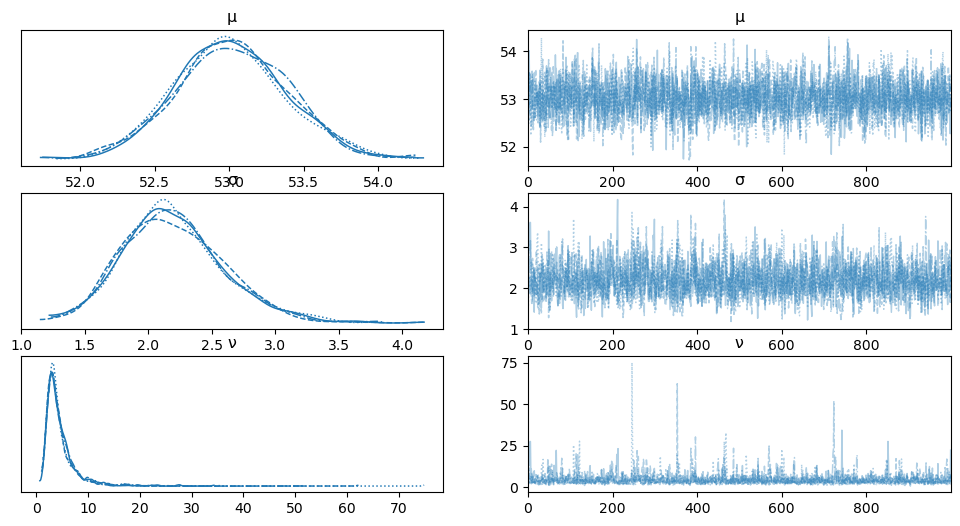

In [25]:
# Plot the trace for `model_t`

az.plot_trace(idata_t)
plt.show()

In [26]:
# Print the summary of `model_t`
az.summary(idata_t, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
μ,53.02,0.38,52.32,53.74
σ,2.20,0.40,1.49,2.97
ν,4.58,3.52,1.13,9.66


In [27]:
# Compare these results to those from `model_g`
az.summary(idata_g, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
μ,53.50,0.50,52.54,54.44
σ,3.54,0.38,2.84,4.23


Sampling: [y]


Output()

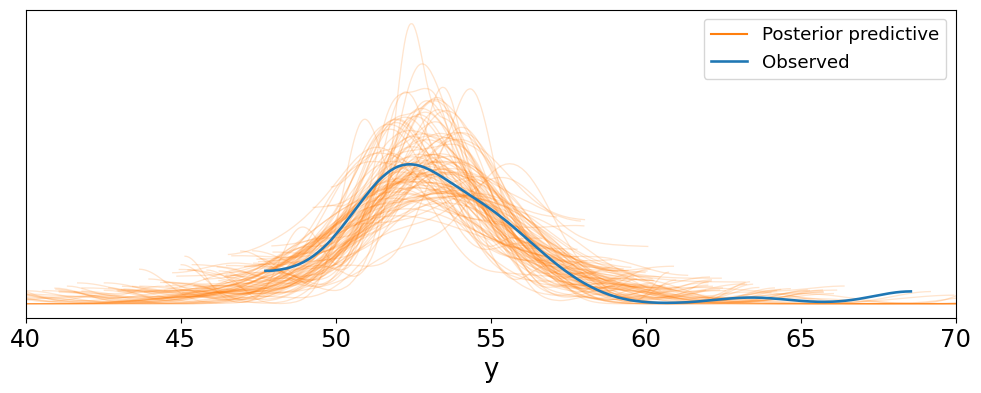

In [28]:
# Plot the posterior predictive check
pm.sample_posterior_predictive(
    idata_t,
    model=model_t,
    extend_inferencedata=True
)
ax = az.plot_ppc(idata_t,
            figsize=(12, 4),
            num_pp_samples=100,
            mean=False,
            colors=['C1', 'C0', 'C1']
)
ax.set_xlim(40, 70)

plt.show()